In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn import linear_model
from scipy import stats 
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from itertools import combinations 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16});
plt.style.use('dark_background')
dt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # dark theme colors
# figdir = '/Users/aqib/Desktop/UCSB/Research/BCCL/adp1/slides/'
import seaborn as sns
import pickle
from Bio import SeqIO # biopython package
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from bioservices import UniProt 
import os

In [2]:
def plotCounts(cts,cts_mean,tags,this_gene=0,title='n/a'):
    fig,ax = plt.subplots(figsize=(4,3))
    ax.set_title(title + ', '+ tags[this_gene])
#     ax.set_text(cts.index[this_gene])
    for ii in range(cts.shape[1]):
        this_col = cts.columns[ii].split('R')[0]
        ax.plot(this_col,cts.iloc[this_gene,ii],'o',c='white',ms=10,mfc='k',mew=2)
        if (ii+1)%nreps == 0:
            ax.hlines(cts_mean.iloc[this_gene,ii//nreps],ii//nreps-0.25,ii//nreps+0.25,
                      color=dt_colors[3],linewidth=2)
    ax.set_ylabel('normalized count')
#     plt.savefig(figdir+title+'.pdf',dpi=300,transparent=True,bbox_inches='tight')  

    
def plotMA():
    
    return 0

### Import DESeq2 normalized counts and results

In [3]:
cts_norm = pd.read_csv('count_matrix_filtered_normalized.csv',index_col=0)
tags = list(cts_norm.index)
res_LB1_LB0 = pd.read_csv('condition_LB1_vs_LB0_results.csv',index_col=0)
res_M9LQ_LB0 = pd.read_csv('condition_M9LQ_vs_LB0_results.csv',index_col=0)
res_M9SF_LB0 = pd.read_csv('condition_M9SF_vs_LB0_results.csv',index_col=0)
res_M9LQ_LB1 = pd.read_csv('condition_M9LQ_vs_LB1_results.csv',index_col=0)
res_M9SF_LB1 = pd.read_csv('condition_M9SF_vs_LB1_results.csv',index_col=0)
res_M9SF_M9LQ = pd.read_csv('condition_M9SF_vs_M9LQ_results.csv',index_col=0)

In [4]:
# create a dictionary that contains the results
# the second condition name in each key is the reference
res = {'LB1vsLB0':res_LB1_LB0,'M9LQvsLB0':res_M9LQ_LB0,'M9SFvsLB0':res_M9SF_LB0,
       'M9LQvsLB1':res_M9LQ_LB1,'M9SFvsLB1':res_M9SF_LB1,'M9SFvsM9LQ':res_M9SF_M9LQ}

In [5]:
# get replicate averages and standard deviations
nreps = 3
cts_mean = cts_norm.groupby(np.arange(len(cts_norm.columns)) // nreps, axis=1).mean()
cts_mean.columns = ['LB0','LB1','M9LQ','M9SF']
cts_std = cts_norm.groupby(np.arange(len(cts_norm.columns)) // nreps, axis=1).std()
cts_std.columns = ['LB0','LB1','M9LQ','M9SF']

## Exploring the results

### Genes with smallest and largest fold changes

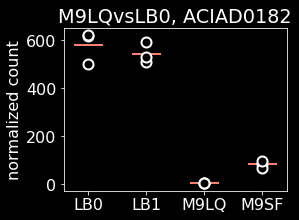

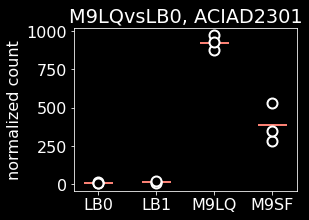

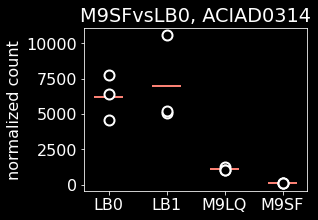

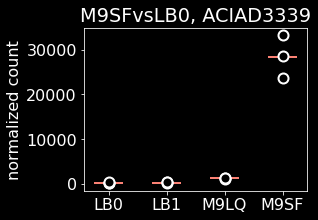

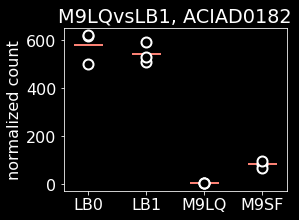

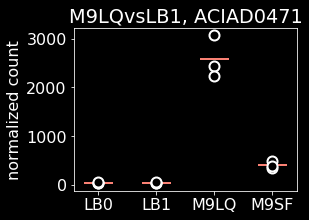

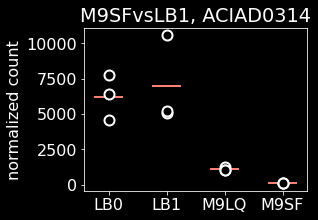

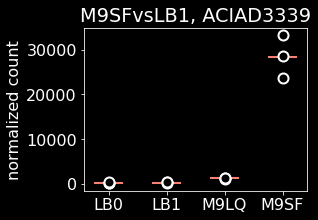

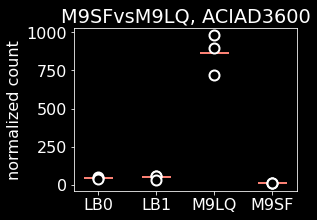

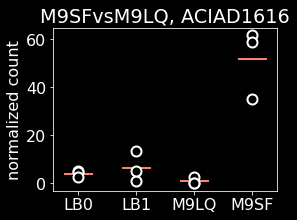

In [6]:
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmin(res['M9LQvsLB0'].log2FoldChange),title='M9LQvsLB0')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmax(res['M9LQvsLB0'].log2FoldChange),title='M9LQvsLB0')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmin(res['M9SFvsLB0'].log2FoldChange),title='M9SFvsLB0')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmax(res['M9SFvsLB0'].log2FoldChange),title='M9SFvsLB0')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmin(res['M9LQvsLB1'].log2FoldChange),title='M9LQvsLB1')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmax(res['M9LQvsLB1'].log2FoldChange),title='M9LQvsLB1')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmin(res['M9SFvsLB1'].log2FoldChange),title='M9SFvsLB1')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmax(res['M9SFvsLB1'].log2FoldChange),title='M9SFvsLB1')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmin(res['M9SFvsM9LQ'].log2FoldChange),title='M9SFvsM9LQ')
plotCounts(cts_norm,cts_mean,tags,this_gene=np.argmax(res['M9SFvsM9LQ'].log2FoldChange),title='M9SFvsM9LQ')

In [7]:
res['LB1vsLB0']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ACIAD0001,319.113032,0.226240,0.184526,1.226057,0.220177,0.995379
ACIAD0002,267.286740,0.251775,0.218269,1.153508,0.248702,0.995379
ACIAD0003,171.841246,-0.107072,0.189647,-0.564587,0.572355,0.995379
ACIAD0004,950.004629,-0.016870,0.178578,-0.094469,0.924737,0.995379
ACIAD0005,94.853847,0.687257,0.496649,1.383788,0.166423,0.995379
...,...,...,...,...,...,...
ACIAD3680,93.559352,0.088512,0.170632,0.518729,0.603950,0.995379
ACIAD3681,583.981712,0.106479,0.225556,0.472074,0.636874,0.995379
ACIAD3682,78.605044,0.284493,0.251520,1.131095,0.258015,0.995379
ACIAD3683,101.607678,0.287518,0.296872,0.968492,0.332798,0.995379


### M (log-ratio) A (average) plot

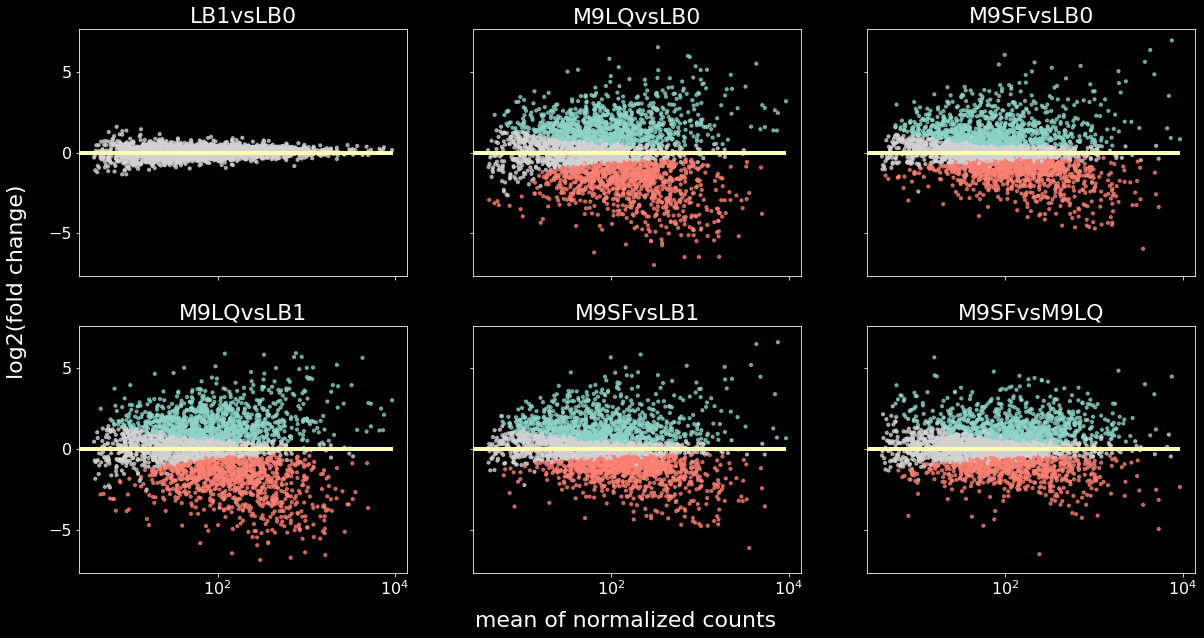

In [8]:
fig,axs = plt.subplots(2,3,figsize=(20,10),sharex=True,sharey=True)
plt.rcParams.update({'font.size':22});
for comp,ax in zip(res,axs.reshape(-1)):
    ax.set_title(comp,fontsize=22)
    these_colors = ['lightgray'] * len(res[comp])
    for ii,elem in enumerate(res[comp].padj<0.05):
        if elem == True and res[comp].log2FoldChange[ii] > 0:
            these_colors[ii] = dt_colors[0]
        elif elem == True and res[comp].log2FoldChange[ii] < 0:
            these_colors[ii] = dt_colors[3]
    ax.scatter(res[comp].baseMean,res[comp].log2FoldChange,s=10,c=these_colors,alpha=0.75)
    ax.hlines(0,np.min(res[comp].baseMean)-100,np.max(res[comp].baseMean)+100,color=dt_colors[1],linewidth=4)
# axs[0,0].l
ax.set_xscale('log')
fig.text(0.4,0.05,'mean of normalized counts',fontsize=22) # xlabel
fig.text(0.075,0.4,'log2(fold change)',rotation='vertical',fontsize=22) # ylabel
# plt.savefig(figdir+'MAplots.pdf',dpi=300,transparent=True,bbox_inches='tight')  
# plt.tight_layout()
plt.show()

### Volcano plot

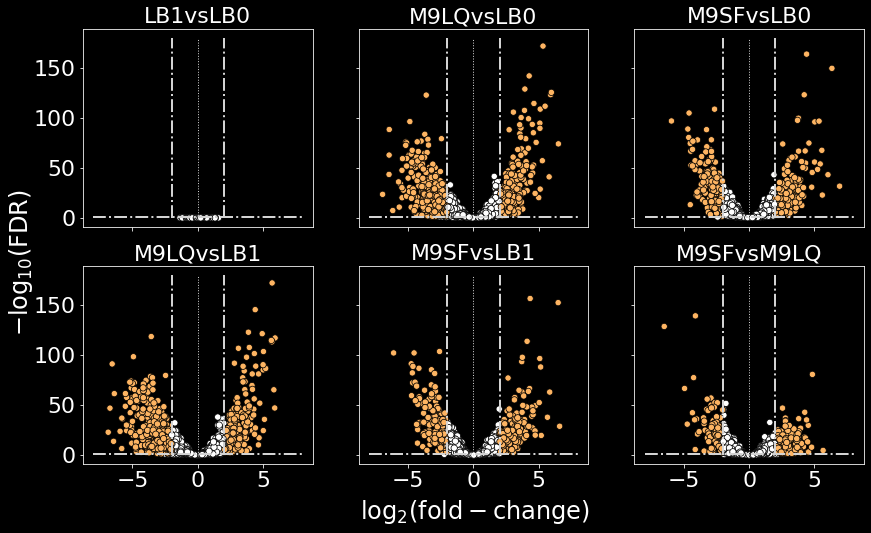

In [9]:
fig,axs = plt.subplots(2,3,figsize=(14,8),sharex=True,sharey=True)
# plt.rcParams.update({'font.size':16});
for comp,ax in zip(res,axs.reshape(-1)):
    ax.set_title(comp,fontsize=22)
    these_colors = ['white'] * len(res[comp])
    for ii,elem in enumerate(res[comp].padj<0.05):
        if elem == True and (np.abs(res[comp].log2FoldChange)[ii] > 2):
            these_colors[ii] = dt_colors[5]
    ax.scatter(res[comp].log2FoldChange,-np.log10(res[comp].padj),s=40,c=these_colors,edgecolors='k',
              linewidths=0.75)
    ax.hlines(-np.log10(0.05),-8,8,color='lightgray',linewidth=2,linestyles='dashdot')
    ax.vlines(2,0,180,color='lightgray',linewidth=2,linestyles='dashdot')
    ax.vlines(-2,0,180,color='lightgray',linewidth=2,linestyles='dashdot')
    ax.vlines(0,0,180,color='lightgray',linewidth=1,linestyles='dotted')
# axs[0,0].set_xlim(-8,8)
# axs[0,0].set_ylim(-5,180)
# ax.set_xscale('log')
fig.text(0.4,0.03,r'$\log_2(\mathrm{fold-change})$',fontsize=24) # xlabel
fig.text(0.05,0.36,r'$-\log_{10}(\mathrm{FDR})$',rotation='vertical',fontsize=24) # ylabel
# plt.savefig(figdir+'volcanoplots.pdf',dpi=300,transparent=True,bbox_inches='tight')  
# plt.tight_layout()
plt.show()

### Make list of significantly disregulated genes in each comparison (sorted by log2FoldChange)

In [10]:
# get genes with padj less than 0.05 and abs(log2fc > c)
resSig = {}
for key in res: 
    resSig[key] = (res[key].loc[res[key].padj < 0.05]) # .sort_values('log2FoldChange')
    resSig[key] = resSig[key].loc[np.abs(resSig[key].log2FoldChange) > 2.0].sort_values('log2FoldChange')

In [11]:
# # write to csv
# for key in disregulated: 
#     disregulated[key].to_csv('disregulated_'+key+'.csv',index=True)

#### relevant sets of DE genes

In [12]:
# set of all DE genes exclusive of condition
allDE = set()
for key in resSig:
    allDE = allDE.union(resSig[key].index)
    print(len(allDE))

0
706
859
938
961
1012


In [13]:
cts_norm.loc['ACIAD2301']

LB0R1      13.395033
LB0R2       9.751384
LB0R3       6.496145
LB1R1      18.026311
LB1R2       7.961880
LB1R3      23.008734
M9LQR1    973.529209
M9LQR2    873.735636
M9LQR3    928.810826
M9SFR1    284.038969
M9SFR2    527.947295
M9SFR3    348.443004
Name: ACIAD2301, dtype: float64

In [14]:
resSig['M9SFvsLB0'].iloc[list(resSig['M9SFvsLB0'].index).index('ACIAD0005')]

baseMean          9.485385e+01
log2FoldChange    2.598391e+00
lfcSE             4.240691e-01
stat              6.127282e+00
pvalue            8.939273e-10
padj              4.238425e-09
Name: ACIAD0005, dtype: float64

In [15]:
# DE genes in M9LQ with respect to LB
M9LQvsLB = set(resSig['M9LQvsLB0'].index).union(resSig['M9LQvsLB1'].index)
# DE genes in M9SF with respect to LB
M9SFvsLB = set(resSig['M9SFvsLB0'].index).union(resSig['M9SFvsLB1'].index)
# DE genes in any M9 condition with respect to LB (A union B)
M9vsLB_union = M9LQvsLB.union(M9SFvsLB)
# DE genes in both M9 conditions with respect to LB (A intersect B)
M9vsLB_intersect = M9LQvsLB.intersection(M9SFvsLB)
# DE genes in only M9LQ with respect to LB (M9SF was not DE)
M9LQ_DE_only = (M9LQvsLB - (M9LQvsLB.intersection(M9SFvsLB))).intersection(resSig['M9SFvsM9LQ'].index)
# M9LQ_DE_only = (M9LQvsLB - M9SFvsLB).intersection(resSig['M9SFvsM9LQ'].index)
# DE genes in only M9SF with respect to LB (M9LQ was not DE)
M9SF_DE_only = (M9SFvsLB - M9LQvsLB).intersection(resSig['M9SFvsM9LQ'].index)

In [16]:
M9vsLB_intersect

{'ACIAD0005',
 'ACIAD0008',
 'ACIAD0021',
 'ACIAD0048',
 'ACIAD0076',
 'ACIAD0079',
 'ACIAD0089',
 'ACIAD0095',
 'ACIAD0096',
 'ACIAD0106',
 'ACIAD0108',
 'ACIAD0109',
 'ACIAD0119',
 'ACIAD0120',
 'ACIAD0121',
 'ACIAD0123',
 'ACIAD0180',
 'ACIAD0182',
 'ACIAD0183',
 'ACIAD0184',
 'ACIAD0185',
 'ACIAD0186',
 'ACIAD0187',
 'ACIAD0188',
 'ACIAD0221',
 'ACIAD0299',
 'ACIAD0301',
 'ACIAD0302',
 'ACIAD0304',
 'ACIAD0305',
 'ACIAD0306',
 'ACIAD0308',
 'ACIAD0314',
 'ACIAD0316',
 'ACIAD0317',
 'ACIAD0332',
 'ACIAD0333',
 'ACIAD0367',
 'ACIAD0372',
 'ACIAD0471',
 'ACIAD0472',
 'ACIAD0499',
 'ACIAD0501',
 'ACIAD0502',
 'ACIAD0549',
 'ACIAD0565',
 'ACIAD0574',
 'ACIAD0575',
 'ACIAD0576',
 'ACIAD0577',
 'ACIAD0587',
 'ACIAD0588',
 'ACIAD0593',
 'ACIAD0609',
 'ACIAD0648',
 'ACIAD0658',
 'ACIAD0666',
 'ACIAD0667',
 'ACIAD0668',
 'ACIAD0721',
 'ACIAD0733',
 'ACIAD0734',
 'ACIAD0735',
 'ACIAD0736',
 'ACIAD0737',
 'ACIAD0738',
 'ACIAD0739',
 'ACIAD0740',
 'ACIAD0742',
 'ACIAD0743',
 'ACIAD0749',
 'ACIA

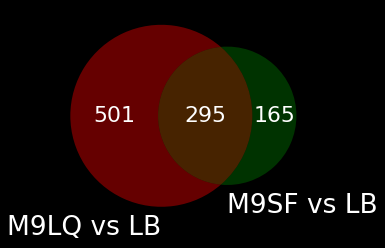

In [17]:
from matplotlib_venn import venn2
venn2([M9LQvsLB,M9SFvsLB],('M9LQ vs LB','M9SF vs LB'))

In [18]:
cts_norm

,LB0R1,LB0R2,LB0R3,LB1R1,LB1R2,LB1R3,M9LQR1,M9LQR2,M9LQR3,M9SFR1,M9SFR2,M9SFR3
ACIAD0001,451.245159,325.901510,488.510070,512.247679,468.866241,493.409522,163.962814,145.622606,111.984284,227.009703,200.900298,239.696491
ACIAD0002,365.014637,296.134128,371.579468,495.723561,329.975675,404.783286,64.047974,107.868597,105.396973,222.580245,179.408638,264.927701
ACIAD0003,284.644442,254.562440,213.073541,195.285039,260.972719,241.165621,176.772409,126.745602,128.452561,55.091379,60.737299,64.591897
ACIAD0004,1645.914626,1487.855872,1262.850501,1382.017200,1808.231315,1157.254111,458.583496,450.351393,487.461001,412.770081,415.816896,430.949060
ACIAD0005,5.023137,6.158769,6.496145,18.026311,6.192573,6.817403,353.544818,388.326949,237.143190,27.407269,52.327520,30.782076
...,...,...,...,...,...,...,...,...,...,...,...,...
ACIAD3680,145.670979,133.953219,131.222120,148.717068,145.083139,144.017632,38.428785,35.057294,32.936554,54.537697,56.065200,57.022534
ACIAD3681,967.791103,1053.149448,863.987226,1048.530441,1049.198796,1010.679953,128.095949,113.262027,125.158906,250.264355,128.949959,268.712382
ACIAD3682,144.833790,109.318144,131.222120,162.236802,167.199471,138.904580,2.561919,5.393430,6.587311,20.486241,18.688400,35.828318
ACIAD3683,121.392483,117.529836,187.088963,220.822313,130.928686,167.026367,2.561919,5.393430,13.174622,72.255527,63.540559,117.577437


In [19]:
thresh_list = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6.5]
num_DEs_for_thresh = []
for thresh in thresh_list:
    # get genes with padj less than 0.05 and abs(log2fc > c)
    resSig = {}
    for key in res: 
        resSig[key] = (res[key].loc[res[key].padj < 0.05]) # .sort_values('log2FoldChange')
        resSig[key] = resSig[key].loc[np.abs(resSig[key].log2FoldChange) > thresh].sort_values('log2FoldChange')

    # set of all DE genes exclusive of condition
    allDE = set()
    for key in resSig:
        allDE = allDE.union(resSig[key].index)
    num_DEs_for_thresh.append(len(allDE))
    print(len(allDE))

2693
2237
1592
1012
673
419
259
143
95
53
6


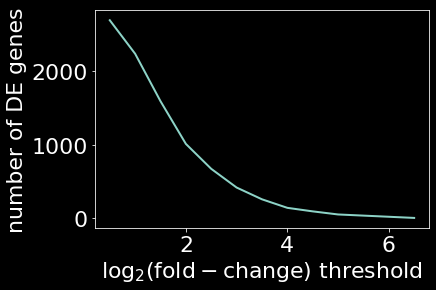

In [20]:
plt.figure()
plt.plot(thresh_list,num_DEs_for_thresh,lw=2)
plt.ylabel('number of DE genes')
plt.xlabel(r'$\log_2(\mathrm{fold-change})$ threshold')
plt.show()